In [1]:
import networkx as nx 
from skimage import io
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
from utils.TripletDataset import TripletNetworkDataset
from utils.SASEFE_dataset import VideoSaseFEdatasetSingle
from networks.networks import *
from torchvision import models
import torch
import torch.nn as nn
import numpy as np
import time
import yaml
from utils.utils import *
from pathlib import Path
import random
from PIL import Image
from argparse import ArgumentParser
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from torch.utils.data import Subset, DataLoader, random_split
import numpy as np
import sys
import sys
sys.path.append('..')
import torch
import torchvision
import torchvision.transforms as transforms
from torchsummary import summary
import matplotlib.pyplot as plt
from utils.TripletDataset import TripletNetworkDataset
import os
from tqdm.auto import tqdm
import yaml
from utils.utils import *
from torch.utils.tensorboard import SummaryWriter
import wandb
import math
from utils.AverageMeter import AverageMeter
from utils.train_epochs import train_epoch, val_epoch, validate
input_type= "video"
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device
random.seed(42)
transform = transforms.ToPILImage()
# !wandb login f7d09dd4e236f76cbd35c414e968ae2c33de7074

In [2]:
def init_optim(model: torch.nn, optim: torch.optim, lr: float, decay: float):
    if optim == "adam":
        return torch.optim.Adam(model.parameters(), lr=lr, weight_decay=decay)
    elif optim == "sgd":
        return torch.optim.SGD(model.parameters(), lr=lr, weight_decay=decay)
    else:
        raise TypeError("Optim %s is not allowed." % optim)

In [3]:
config_path = "configs/template_train_lstm.yaml"
with open(config_path, "r") as stream:
    config = yaml.safe_load(stream)

# make params accessible by dot notation
params = config["training_params"]
datamodule = config["datamodule"]
num_classes = params["num_classes"]

train_dataset, val_dataset, test_dataset= init_dataset(datamodule["dataset_dir"],datamodule["n_frames"], num_classes, test_size=5, type=datamodule["type"])

In [4]:
len(train_dataset), len(val_dataset), len(test_dataset)

(478, 120, 120)

In [26]:
int2emo={
        0:"Fake-Angry",
        1:"Fake-Contempt",
        2:"Fake-Disgust",
        3:"Fake-Happy",
        4:"Fake-Sad",
        5:"Fake-Surprise",
        6:"Real-Angry",
        7:"Real-Contempt",
        8:"Real-Disgust",
        9:"Real-Happy",
        10:"Real-Sad",
        11:"Real-Surprise"
        
}

'Real-Angry'

IndexError: invalid index to scalar variable.

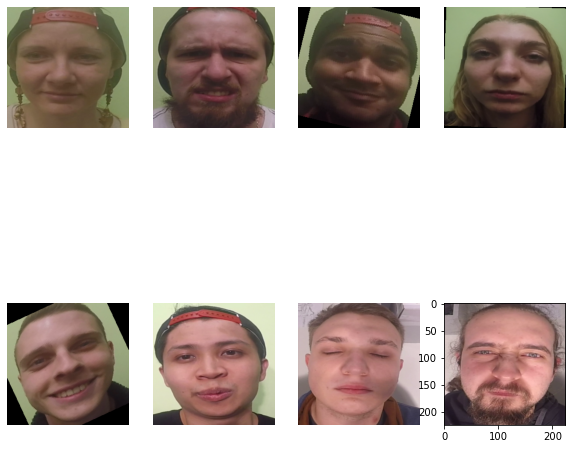

In [17]:
from PIL import Image
import torchvision.transforms as T
transform = T.ToPILImage()
transform(train_dataset[19][0][4])
# fig = plt.figure(figsize=(10, 15))
fig, ax = plt.subplots(2, 4, figsize=(10, 10))
# fig.add_subplot(1,4, 1)
ax[0,0].imshow(transform(train_dataset[19][0][4]), cmap='gray')
ax[0,0].axis('off')
ax[0,1].imshow(transform(train_dataset[26][0][10]), cmap='gray')
ax[0,1].axis('off')
ax[0,2].imshow(transform(train_dataset[111][0][4]), cmap='gray')
ax[0,2].axis('off')
ax[0,3].imshow(transform(train_dataset[221][0][4]), cmap='gray')
ax[0,3].axis('off')
ax[1,0].imshow(transform(train_dataset[255][0][4]), cmap='gray')
ax[1,0].axis('off')
# fig.add_subplot(2,4, 6)
ax[1,1].imshow(transform(train_dataset[465][0][10]), cmap='gray')
ax[1,1].axis('off')
# fig.add_subplot(2,4, 7)
ax[1,2].imshow(transform(train_dataset[432][0][4]), cmap='gray')
ax[1,2].axis('off')
# fig.add_subplot(2,4, 8)
ax[1,3].imshow(transform(train_dataset[90][0][4]), cmap='gray')
ax[1,3].set_title(int2emo[train_dataset[90][1]])
ax[1,3].axis('off')
plt.tight_layout()

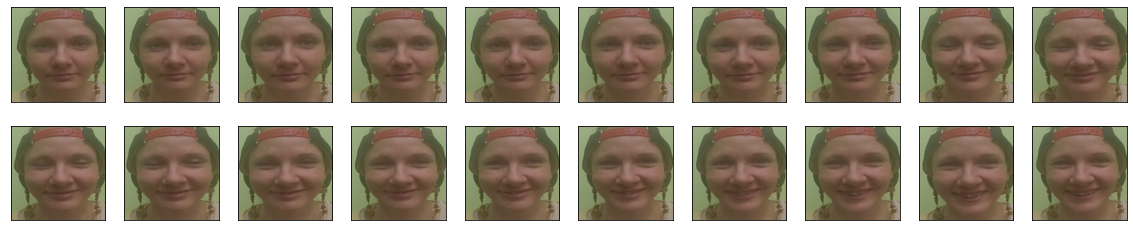

torch.Size([20, 3, 224, 224])

In [7]:
def show_images(images, col=5,row=5):
    n = images.shape[0]
    row = np.ceil(n / col).astype(int)
    fig = plt.figure(figsize=(2*col, 2*row))
    for i in range(n):
        fig.add_subplot(row, col, i+1)
        plt.imshow((transform(images[i])), cmap='gray')
        plt.xticks([]), plt.yticks([])
    plt.show()

show_images(train_dataset[15][0],10,2)
train_dataset[15][0].shape

In [5]:
int2emo = config["int2emo"]
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)

In [6]:
for x in train_loader:
    break

In [7]:
img, label = x

In [8]:
img.size()

torch.Size([1, 8, 3, 224, 224])

In [9]:
classes = []
for key in int2emo:
    classes.append(int2emo[key])

In [10]:
# plt.imshow(x[0][0][2].permute(1,2,0))


In [11]:
def train(
    model,
    criterion,
    train_loader: DataLoader,
    val_loader: DataLoader,
    optimizer: torch.optim,
    step: int,
    max_epochs: int,
    model_name: str,
):

    prev_epoch_loss = 0.0

    scheduler = torch.optim.lr_scheduler.StepLR(
        optimizer, step_size=step, gamma=0.1, verbose=True
    )

    last_epoch = False
    stop_count = 0

    best_train_loss = [999, -1]
    best_val_loss = [999, -1]
    n_steps_per_epoch = math.ceil(len(train_loader.dataset) / train_loader.batch_size)
    example_ct = 0
    conf_labels = []
    conf_pred = []
    log_input = []
    for epoch in range(1, max_epochs + 1):
        print("Start epoch #%d" % (epoch))
        running_loss = 0.0
        correct = 0

        print("\n\n -- Training --")
        model.train()
        for i, batch in enumerate(tqdm(train_loader, 0)):

            inputs,labels = batch
            labels = labels.type(torch.LongTensor)
            inputs,labels = inputs.to(device), labels.to(device)
            


            if epoch == 1 and i == 0:
                for one_frame in batch[0][0]:
                    log_input.append(transform(one_frame))
                wandb.log(
                    {"input_example": [wandb.Image(image) for image in log_input]}
                )
                wandb.log({"input_size": inputs.size()})
                # print(inputs.size())
                print("logged_input")
                # model.conv1 = nn.Conv2d(inputs.size(dim=1), 64, kernel_size=7, stride=2, padding=3, bias=False)

            optimizer.zero_grad()

            outputs = model(inputs)
            if outputs.shape[-1] == 1:
                labels = labels.unsqueeze(1)

            loss = criterion(outputs, labels)
            loss.backward()

            optimizer.step()

            running_loss += loss.item()
            if i % 100 == 0:
                print(
                    "Progress: {:d}/{:d}. Loss:{:.3f}".format(
                        i, len(train_loader), running_loss / (i + 1)
                    )
                )
            example_ct += len(inputs)
            metrics = {
                "train/train_loss": loss,
                "train/epoch": (i + 1 + (n_steps_per_epoch * epoch))
                / n_steps_per_epoch,
                "train/example_ct": example_ct,
            }
        running_loss = running_loss / len(train_loader)

        if running_loss < best_train_loss[0]:
            # keep track of best train loss
            best_train_loss[0] = running_loss
            best_train_loss[1] = epoch

        if abs(running_loss - prev_epoch_loss) < 0.001:
            print(
                "Early stopping! Epoch: {:d}, Loss: {:.3f}".format(epoch, running_loss)
            )
            stop_count += 1
            if stop_count == 3:
                last_epoch = True
            prev_epoch_loss = running_loss
        else:
            prev_epoch_loss = running_loss
            stop_count = 0

        val_loss, val_prediction, labels = validate(
            model, val_loader, device, criterion
        )
        correct += (val_prediction == labels).sum().item()

        val_metrics = {
            "val/val_loss": val_loss,
            "val/val_accuracy": correct / len(val_loader.dataset),
        }
        print(val_metrics)

        wandb.log({**metrics, **val_metrics})

        # check the loss to save best model and values for conf_matrix
        if val_loss < best_val_loss[0]:
            best_val_loss[0] = val_loss
            best_val_loss[1] = epoch
            conf_labels = labels
            conf_pred = val_prediction
            torch.save(
                model.state_dict(), "checkpoints/" + model_name + "_best.pt"
            )

        # save every 3epochs
        if epoch % 3 == 0:
            torch.save(
                model.state_dict(),
                "checkpoints/" + model_name + "_epoch" + str(epoch) + ".pt",
            )

        scheduler.step()

        if last_epoch:
            break

    # create confusion matrix on Wandb
    wandb.log(
        {
            "conf_mat": wandb.plot.confusion_matrix(
                probs=None, y_true=conf_labels, preds=conf_pred, class_names=classes
            )
        }
    )
    wandb.finish()
    return best_train_loss, best_val_loss

In [2]:
for net in config["models"]:
        # initialize the modelsource            
        model = init_model(net, num_classes, device, embeddings_size=512)
        model.to(device)
        # model.load_state_dict(torch.load("models/best_model.pt"))
        img_name = net+"_"+str(num_classes)

        # We define a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
        wandb_name = (img_name + "_ep_" + str(params["max_epochs"]))
        wandb.init(
            # Set the project where this run will be logged
            project="Distinguish",
            name=f"{wandb_name}",
            # Track hyperparameters and run metadata
            config={
                "learning_rate": params["lr"],
                "model": net,
                "dataset_size": params["size"],
                "image_src": img_name,
                "epochs": params["max_epochs"],
            },
        )
        # Folder to save
        logdir = img_name+"/"+net
        print("\n Training arguments:\n", params, net, img_name)
        print("\nModel log dir:", logdir, "\n")

        optim = init_optim(model, params["optim"], params["lr"], params["decay"])
        criterion = torch.nn.CrossEntropyLoss()
            

        train_dataset, val_dataset, test_dataset,  = init_dataset(datamodule["dataset_dir"], datamodule["n_frames"], n_classes=num_classes, test_size=10, type=datamodule["type"])
        int2emo = config["int2emo"]
        # train_frames=[]
        # val_frames=[]
        # # for video, label in train_dataset:
        # #     for vid in video:
        # #         train_frames.append([vid,label])

        # # for video, label in val_dataset:
        # #     for vid in video:
        # #         val_frames.append([vid,label])

        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=False)
        val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1, shuffle=False)
        # create path to save checkpoints
        if not os.path.exists("checkpoints/" + img_name):
            os.mkdir("checkpoints/" + img_name)
        #classifyer part
        train_loss, val_loss = train(
                        model,
                        criterion,
                        train_loader,
                        val_loader,
                        optim,
                        params["step"],
                        params["max_epochs"],
                        logdir,
                    )

        print("Best train loss:", train_loss)
        print("Best val loss:", val_loss)

NameError: name 'config' is not defined

In [11]:
train_dataset, val_dataset, test_dataset,  = init_dataset(datamodule["dataset_dir"], datamodule["n_frames"], n_classes=num_classes, test_size=10, type=datamodule["type"])
int2emo = config["int2emo"]
# train_frames=[]
# val_frames=[]
# # for video, label in train_dataset:
# #     for vid in video:
# #         train_frames.append([vid,label])

# # for video, label in val_dataset:
# #     for vid in video:
# #         val_frames.append([vid,label])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=False)

In [ ]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')

In [16]:
for i, batch in enumerate(tqdm(train_loader, 0)):
            inputs,labels = batch
            labels = labels.type(torch.LongTensor)
            import torch.nn.functional as Fun
            output = Fun.one_hot(labels, num_classes = 12)
            # inputs,labels = inputs.to(device), labels.to(device)
            
            break

  0%|          | 0/478 [00:00<?, ?it/s]


In [ ]:
for x in train_loader:
    break

In [ ]:
train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, epoch, log_interval=10, device=device)